In [1]:
            import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
BATCH=200
path = r'C:\Users\ЛФКИТ-3\Documents\quantTechLab\data\img'
path2 = r"C:\Users\ЛФКИТ-3\Documents\quantTechLab\data\img3_stripes"

In [3]:
import os
import numpy as np
from pathlib import Path
from torch.utils.data import Dataset
import imageio
from ImageDataset import FolderImageDataset

#[x] TODO: import the dataset from ImageDataset.py and adapt the api
#[ ] TODO: maybe switch to torch.datasets.ImageFolder?

# Dataset resized

In [4]:
# TODO: use transforms for 1) resizing image and 2) taking only green channel
# https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Resize


In [5]:
def condition(a):
    # based on dataset inspection plots
    return (0.120 > a) & (a > 0.105)

In [6]:
# TODO: random sample test data instead of from the end
import skimage
class Resize:
    def __init__(self, size):
        if isinstance(size, int):
            self._size = (size, size)
        else:
            self._size = size

    def __call__(self, img: np.ndarray):
        resize_image = skimage.transform.resize(img, self._size)
        # the resize will return a float64 array
        return skimage.util.img_as_ubyte(resize_image)
    

train_loader_1 = FolderImageDataset(path2, transform=transforms.Compose([
                                Resize((144/2, 192/2)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,)),

]), 
                                    start =  0.3, end = 0.8,
                                   filtered=condition)
test_loader_1 = FolderImageDataset(path2, transform=transforms.Compose([
                                Resize((144/2, 192/2)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,)),


]), start = 0.8, end = 1,
                                  filtered=condition)

In [7]:
train_loader_1.print_target_statistic()

MEAN = 0.11242919792011578 	 MSE = 1.945648964933793e-05 	 SIGMA = 0.004410951104845522


In [8]:
train_loader = torch.utils.data.DataLoader(
        train_loader_1,
     batch_size=BATCH, shuffle=True)
test_loader = torch.utils.data.DataLoader(
        test_loader_1,
batch_size=BATCH, shuffle=True)

In [9]:
len(train_loader_1)

6722

In [40]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        #self.conv3 = nn.Conv2d(50, 60, 5, 1)

        self.fc1 = nn.Linear(14*19*50, 500)
        self.fc2 = nn.Linear(500, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        #print(x.shape)
        x = F.max_pool2d(x, 3, 3)
        x = F.relu(self.conv2(x))
        #print(x.shape)
        x = F.max_pool2d(x, 3, 3)
        #x = F.relu(self.conv3(x))
        #print(x.shape)

        #x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 14*19*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    

class Net05(nn.Module):
    def __init__(self):
        super(Net05, self).__init__()
        self.conv1 = nn.Conv2d(3, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        #self.conv3 = nn.Conv2d(50, 60, 5, 1)

        self.fc1 = nn.Linear(6*8*50, 500)
        self.fc2 = nn.Linear(500, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        #print(x.shape)
        x = F.max_pool2d(x, 3, 3)
        x = F.relu(self.conv2(x))
        #print(x.shape)
        x = F.max_pool2d(x, 3, 3)
        #x = F.relu(self.conv3(x))
        #print(x.shape)

        #x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 6*8*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t mse: {}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), target.std()**2))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0.
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.mse_loss(output, target, reduction='sum').item() # sum up batch loss

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.7f}\n'.format(
        test_loss))

In [41]:
model = Net05()
use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")
optimizer = optim.Adam(model.parameters(), lr=0.002)


In [42]:
%%time
# TODO: draw graph of train test loss
for epoch in range(1, 130):
    train( model, device, train_loader, optimizer, epoch)
    test( model, device, test_loader)


C:\Python\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


Train Epoch: 1 [0/6722 (0%)]	Loss: 0.007503	 mse: 1.9016422811546363e-05
Train Epoch: 1 [2000/6722 (29%)]	Loss: 0.003442	 mse: 1.8243808881379664e-05
Train Epoch: 1 [4000/6722 (59%)]	Loss: 0.000047	 mse: 1.8702254237723537e-05
Train Epoch: 1 [6000/6722 (88%)]	Loss: 0.000039	 mse: 1.9933557268814184e-05

Test set: Average loss: 0.0000591

Train Epoch: 2 [0/6722 (0%)]	Loss: 0.000058	 mse: 1.993354999285657e-05
Train Epoch: 2 [2000/6722 (29%)]	Loss: 0.000031	 mse: 2.0407303964020684e-05
Train Epoch: 2 [4000/6722 (59%)]	Loss: 0.000020	 mse: 1.959308428922668e-05
Train Epoch: 2 [6000/6722 (88%)]	Loss: 0.000017	 mse: 1.7454744011047296e-05

Test set: Average loss: 0.0000256

Train Epoch: 3 [0/6722 (0%)]	Loss: 0.000021	 mse: 1.933197745529469e-05
Train Epoch: 3 [2000/6722 (29%)]	Loss: 0.000017	 mse: 1.7086640582419932e-05
Train Epoch: 3 [4000/6722 (59%)]	Loss: 0.000018	 mse: 1.872187749540899e-05
Train Epoch: 3 [6000/6722 (88%)]	Loss: 0.000019	 mse: 2.1281870431266725e-05

Test set: Average l

Train Epoch: 25 [0/6722 (0%)]	Loss: 0.000010	 mse: 1.7623660824028775e-05
Train Epoch: 25 [2000/6722 (29%)]	Loss: 0.000010	 mse: 1.853091634984594e-05
Train Epoch: 25 [4000/6722 (59%)]	Loss: 0.000014	 mse: 2.052126728813164e-05
Train Epoch: 25 [6000/6722 (88%)]	Loss: 0.000009	 mse: 1.7233187463716604e-05

Test set: Average loss: 0.0000267

Train Epoch: 26 [0/6722 (0%)]	Loss: 0.000014	 mse: 2.081249658658635e-05
Train Epoch: 26 [2000/6722 (29%)]	Loss: 0.000009	 mse: 1.7109861801145598e-05
Train Epoch: 26 [4000/6722 (59%)]	Loss: 0.000012	 mse: 1.7688076695776545e-05
Train Epoch: 26 [6000/6722 (88%)]	Loss: 0.000010	 mse: 1.8337286746827886e-05

Test set: Average loss: 0.0000266

Train Epoch: 27 [0/6722 (0%)]	Loss: 0.000013	 mse: 1.9434306523180567e-05
Train Epoch: 27 [2000/6722 (29%)]	Loss: 0.000009	 mse: 1.9528213670128025e-05
Train Epoch: 27 [4000/6722 (59%)]	Loss: 0.000010	 mse: 2.107325599354226e-05
Train Epoch: 27 [6000/6722 (88%)]	Loss: 0.000013	 mse: 2.0417066480149515e-05

Test se


Train Epoch: 49 [0/6722 (0%)]	Loss: 0.000005	 mse: 2.0451525415410288e-05
Train Epoch: 49 [2000/6722 (29%)]	Loss: 0.000005	 mse: 1.883450022432953e-05
Train Epoch: 49 [4000/6722 (59%)]	Loss: 0.000006	 mse: 2.053993557638023e-05
Train Epoch: 49 [6000/6722 (88%)]	Loss: 0.000005	 mse: 1.9224933566874824e-05

Test set: Average loss: 0.0000245

Train Epoch: 50 [0/6722 (0%)]	Loss: 0.000005	 mse: 1.8197157260146923e-05
Train Epoch: 50 [2000/6722 (29%)]	Loss: 0.000006	 mse: 1.7523416317999363e-05
Train Epoch: 50 [4000/6722 (59%)]	Loss: 0.000006	 mse: 2.1061141524114646e-05
Train Epoch: 50 [6000/6722 (88%)]	Loss: 0.000005	 mse: 2.0212171875755303e-05

Test set: Average loss: 0.0000252

Train Epoch: 51 [0/6722 (0%)]	Loss: 0.000005	 mse: 2.0243687686161138e-05
Train Epoch: 51 [2000/6722 (29%)]	Loss: 0.000004	 mse: 1.9757053451030515e-05
Train Epoch: 51 [4000/6722 (59%)]	Loss: 0.000005	 mse: 1.8008517145062797e-05
Train Epoch: 51 [6000/6722 (88%)]	Loss: 0.000005	 mse: 1.791726754163392e-05

Test 


Train Epoch: 73 [0/6722 (0%)]	Loss: 0.000003	 mse: 1.8972788893734105e-05
Train Epoch: 73 [2000/6722 (29%)]	Loss: 0.000003	 mse: 2.159582800231874e-05
Train Epoch: 73 [4000/6722 (59%)]	Loss: 0.000002	 mse: 1.8494441974326037e-05
Train Epoch: 73 [6000/6722 (88%)]	Loss: 0.000003	 mse: 1.815082760003861e-05

Test set: Average loss: 0.0000287

Train Epoch: 74 [0/6722 (0%)]	Loss: 0.000003	 mse: 1.8831942725228146e-05
Train Epoch: 74 [2000/6722 (29%)]	Loss: 0.000003	 mse: 1.758891266945284e-05
Train Epoch: 74 [4000/6722 (59%)]	Loss: 0.000003	 mse: 2.0059538655914366e-05
Train Epoch: 74 [6000/6722 (88%)]	Loss: 0.000003	 mse: 1.9069826521445066e-05

Test set: Average loss: 0.0000286

Train Epoch: 75 [0/6722 (0%)]	Loss: 0.000003	 mse: 1.8862265278585255e-05
Train Epoch: 75 [2000/6722 (29%)]	Loss: 0.000003	 mse: 1.9648103261715733e-05
Train Epoch: 75 [4000/6722 (59%)]	Loss: 0.000004	 mse: 1.944043287949171e-05
Train Epoch: 75 [6000/6722 (88%)]	Loss: 0.000003	 mse: 2.0280071112210862e-05

Test s


Train Epoch: 97 [0/6722 (0%)]	Loss: 0.000001	 mse: 2.1117246433277614e-05
Train Epoch: 97 [2000/6722 (29%)]	Loss: 0.000002	 mse: 1.7860202206065878e-05
Train Epoch: 97 [4000/6722 (59%)]	Loss: 0.000001	 mse: 1.9865618014591746e-05
Train Epoch: 97 [6000/6722 (88%)]	Loss: 0.000003	 mse: 2.1867203031433746e-05

Test set: Average loss: 0.0000295

Train Epoch: 98 [0/6722 (0%)]	Loss: 0.000002	 mse: 1.9206941942684352e-05
Train Epoch: 98 [2000/6722 (29%)]	Loss: 0.000001	 mse: 1.939808680617716e-05
Train Epoch: 98 [4000/6722 (59%)]	Loss: 0.000002	 mse: 1.8900063878390938e-05
Train Epoch: 98 [6000/6722 (88%)]	Loss: 0.000002	 mse: 1.8963606635225005e-05

Test set: Average loss: 0.0000307

Train Epoch: 99 [0/6722 (0%)]	Loss: 0.000001	 mse: 1.8440536223351955e-05
Train Epoch: 99 [2000/6722 (29%)]	Loss: 0.000002	 mse: 1.8780145182972774e-05
Train Epoch: 99 [4000/6722 (59%)]	Loss: 0.000002	 mse: 1.7909242160385475e-05
Train Epoch: 99 [6000/6722 (88%)]	Loss: 0.000001	 mse: 2.01247567019891e-05

Test 

Train Epoch: 120 [4000/6722 (59%)]	Loss: 0.000001	 mse: 2.0785058950423263e-05
Train Epoch: 120 [6000/6722 (88%)]	Loss: 0.000001	 mse: 1.9578044884838164e-05

Test set: Average loss: 0.0000303

Train Epoch: 121 [0/6722 (0%)]	Loss: 0.000001	 mse: 1.9069424524786882e-05
Train Epoch: 121 [2000/6722 (29%)]	Loss: 0.000001	 mse: 2.139355092367623e-05
Train Epoch: 121 [4000/6722 (59%)]	Loss: 0.000001	 mse: 2.0282062905607745e-05
Train Epoch: 121 [6000/6722 (88%)]	Loss: 0.000001	 mse: 2.112077345373109e-05

Test set: Average loss: 0.0000307

Train Epoch: 122 [0/6722 (0%)]	Loss: 0.000001	 mse: 1.878030707302969e-05
Train Epoch: 122 [2000/6722 (29%)]	Loss: 0.000001	 mse: 1.9417320800130256e-05
Train Epoch: 122 [4000/6722 (59%)]	Loss: 0.000001	 mse: 1.8757913494482636e-05
Train Epoch: 122 [6000/6722 (88%)]	Loss: 0.000001	 mse: 1.974939186766278e-05

Test set: Average loss: 0.0000290

Train Epoch: 123 [0/6722 (0%)]	Loss: 0.000001	 mse: 1.906383658933919e-05
Train Epoch: 123 [2000/6722 (29%)]	Loss:

# Затраченное время

Датасет img2: ~50 мин (2.9к на train, 2.9k на test), test loss = 1.2E-5, epochs = 10

Датасет img3 resize0.5x: 20 мин (10к на train, 10k на test), test loss = 6.66E-5, epochs = 10

Датасет img3: 35 мин (10к на train, 10k на test), test loss = 5.4E-5, epochs = 3

Датасет img3: ~120 мин (10к на train, 10k на test), test loss = 6.3E-5, epochs = 10

Датасет img3, 0.3-0.8: ~30 мин (6.7к на train, 4k на test), test loss = 2.3E-5, epochs = 5

Датасет img3, 0.3-0.8: 12ч (6.7к на train, 4k на test), test loss = 3.6E-5, train loss=3E-6, epochs = 130

Датасет img3 0.3-0.8; resize0.5x: 4ч (6.7к на train, 4k на test), test loss = 3E-5, train loss=1E-6, epochs = 130



Ожидаемо время возрасло в 4 раза

In [56]:
for x,y in test_loader:
    break

C:\Python\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [57]:
pred = model(x)

In [58]:
pred_np = np.array(pred.reshape(-1).detach())
y_np =  np.array(y)

In [59]:
import matplotlib.pyplot as plt


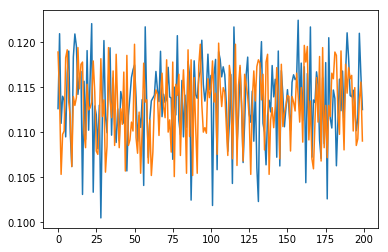

In [60]:
plt.plot(pred_np)
plt.plot(y_np)
plt.show()

Text(0.5,1,'img3х05, 130epoch, train val')

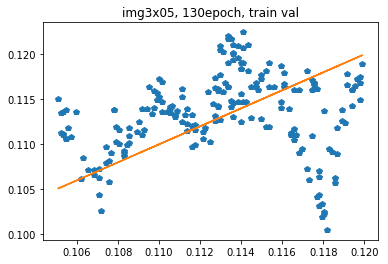

In [61]:

plt.plot(y_np, pred_np, 'p')
plt.plot(y_np, y_np)
plt.title("img3х05, 130epoch, train val")

In [49]:
intensity = np.zeros(len(valid_data))
phases = np.zeros(len(valid_data))

In [50]:
for i in range(len(valid_data)):
    intensity[i] = valid_data[i][0].mean()
    phases[i] = valid_data[i][1] 

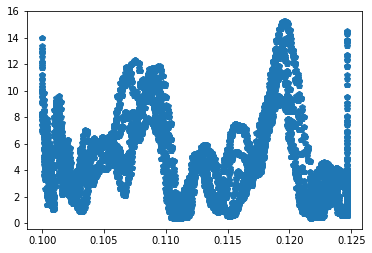

In [62]:
plt.plot(phases10[:000], intensity[:10000], 'p')

In [21]:
plt.plot(phases, intensity, 'p')

NameError: name 'phases' is not defined